# Import Modules, Environments and the Sketch Image

In [ ]:
from io import BytesIO
import os
import subprocess
import sys
from gradio_client import Client, handle_file
import random
import requests
import json
import base64
from PIL import Image
import datetime
import shutil
from pathlib import Path
from IPython.display import IFrame
import asyncio

In [23]:
# define virtual envs
flowty_env = r"E:\anaconda\envs\flowty_env\python.exe"  # Windows flowty_env Python path

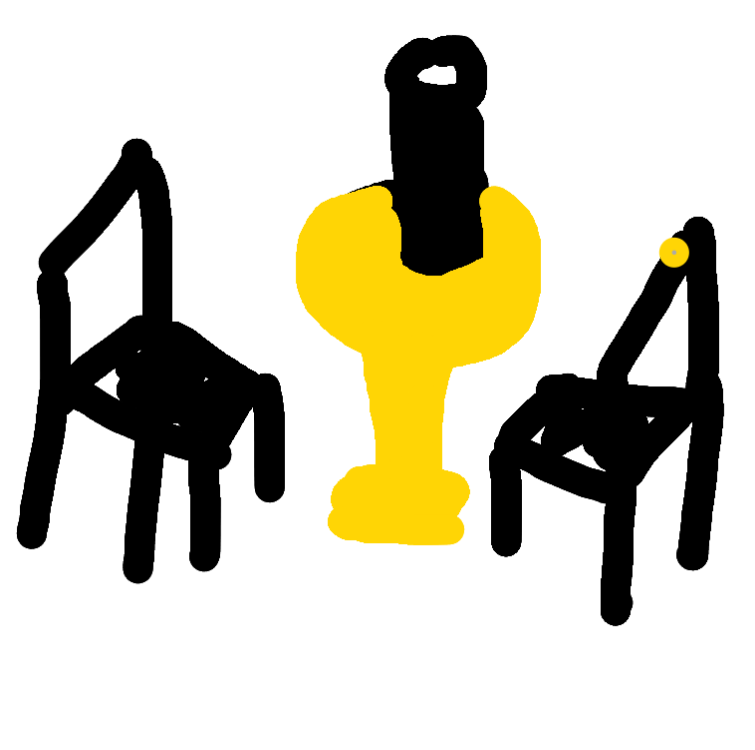

In [5]:
# save your sketch path and preview
sketch_path = "sketch_sample.png"
with open("sketch_path.txt", "w") as f:
    f.write(sketch_path)
Image.open(sketch_path)

# Sketch to Image Stage

## Prompts

In [7]:
Prompt = input('Please simply describe your sketch with few words: ')

Please simply describe your sketch with few words:  two chairs, one table, one basket


In [9]:
# save prompts from the user
with open("UserPrompt.txt", "w") as f:
    f.write(str(Prompt))

## Sketch to Image: flowty-realtime-lcm-canvas

In [11]:
# run sketch_to_image
sketch_to_image_process = subprocess.Popen(
    'conda run -n flowty_env python flowty-realtime-lcm-canvas/ui.py',
    # capture_output=True,
    text=True,
    shell=True
)
await asyncio.sleep(3)

In [15]:
subprocess.run(
    'conda run -n flowty_env python sketch_to_image.py',
    # capture_output=True,
    text=True,
    check=True
)

CompletedProcess(args='conda run -n flowty_env python sketch_to_image.py', returncode=0)

In [17]:
sketch_to_image_process.terminate()

## Save the generated image and preview

In [19]:
with open("output.txt", "r") as f:
    sketch_to_image_result = f.read().strip()

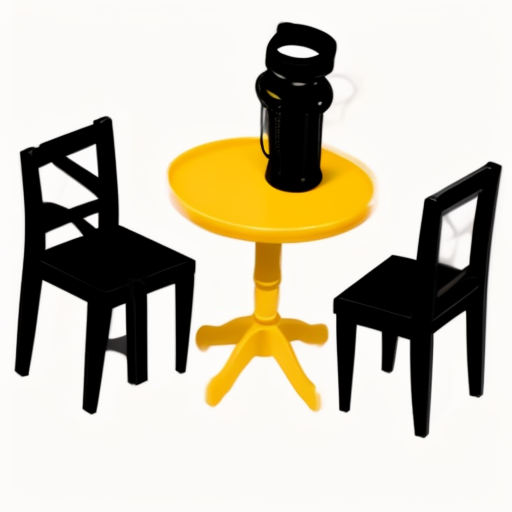

In [21]:
Image.open(sketch_to_image_result)

# Image refinement Stage

In [15]:
# run the following cell if you have not launched sd-webui

## Image refinement with StableDiffusion

In [48]:
# use time as filenames
time = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
time = time
# API port
url = "http://127.0.0.1:7862"

def img_to_base64(image_path):
    """turn image to Base64"""
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def base64_to_img(base64_str):
    """turn Base64 back to image"""
    image_data = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_data))

def img2img(
    input_image_path,
    prompt="a beautiful landscape, trending on artstation, high quality",
    negative_prompt="ugly, blurry, low quality",
    seed=-1,
    steps=30,
    cfg_scale=10,
    denoising_strength=0.65,
    output_dir="output"
):
    
    # read images
    image_b64 = img_to_base64(input_image_path)
    
    # set up api
    payload = {
        "init_images": [image_b64],
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "seed": seed,
        "steps": steps,
        "cfg_scale": cfg_scale,
        "denoising_strength": denoising_strength,
        "sampler_name": "DPM++ 2M",  # sampler name
        "width": 512,
        "height": 512,
        "restore_faces": True
    }
    
    # send request
    response = requests.post(url=f'{url}/sdapi/v1/img2img', json=payload)
    
    if response.status_code == 200:
        # get the result
        result = response.json()
        
        # make sure the dir exists
        os.makedirs(output_dir, exist_ok=True)
        
        # save the generated image
        for i, img_data in enumerate(result['images']):
            image = base64_to_img(img_data)
            time = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
            output_path = os.path.join(output_dir, f"{time}_{i}.png")
            image.save(output_path)
            print(f"Image Saved to: {output_path}")
    else:
        print(f"Request failed，status_code: {response.status_code}")
        print(f"Error: {response.text}")

    return output_path

if __name__ == "__main__":
    # Sample
    refined_image_path = img2img(
        input_image_path=sketch_to_image_result,  # replace with the path of the input image
        prompt='realistic' + Prompt,
    )

Image Saved to: output\2025-05-13 16_51_46_0.png


## Save Image and Preview

In [54]:
file_name = refined_image_path[7:]
file_name

'2025-05-13 16_51_46_0.png'

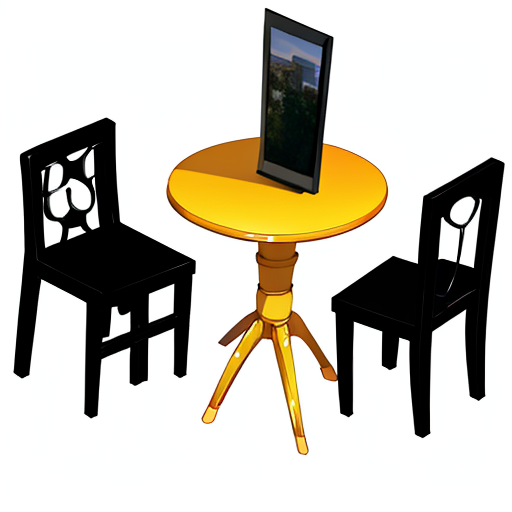

In [50]:
Image.open(refined_image_path)

# Segmentation Stage

It is suggested that you run the segmentation in MIDI-3D webui so that you could manually set the number of objects and their positions.

## segmentation and preview

In [56]:
seg_cmd = [
    "python",
    "-m",
    "MIDI-3D.scripts.grounding_sam",
    "--image", refined_image_path,
    "--labels", "chair photo wall floor",
    "--output", f"./segmentation/{file_name}"
]

subprocess.run(
    seg_cmd,
    text=True, 
    check=True,
)

CompletedProcess(args=['python', '-m', 'MIDI-3D.scripts.grounding_sam', '--image', 'output\\2025-05-13 16_51_46_0.png', '--labels', 'chair photo wall floor', '--output', './segmentation/2025-05-13 16_51_46_0.png'], returncode=0)

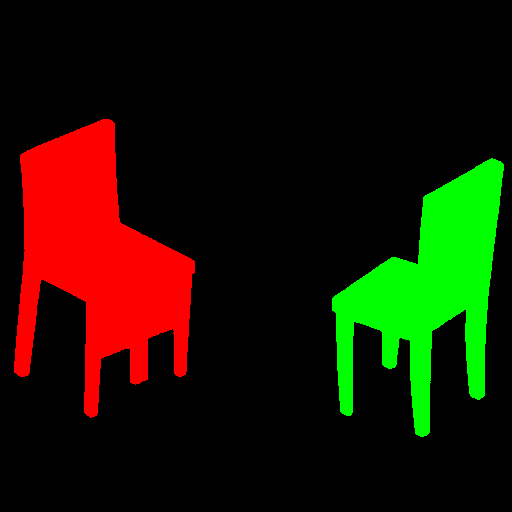

In [58]:
seg_img_path = f"segmentation/{file_name}/segmentation.png"
Image.open(seg_img_path)

# Model generation Stage

## Copy files to prepare for generation
Copy the initial image and the segmented image to specific paths 

In [60]:
# rgb source
src_rgb_image = refined_image_path
# dst rgb folder
dst_rgb_folder = f"MIDI-3D/assets/{time}/rgb/"

# source
src_seg_image = seg_img_path
# dst seg folder
dst_seg_folder = f"MIDI-3D/assets/{time}/seg/"

# make sure dst folders exsit
Path(dst_rgb_folder).mkdir(parents=True, exist_ok=True)
Path(dst_seg_folder).mkdir(parents=True, exist_ok=True)


# copy
shutil.copy2(src_rgb_image, dst_rgb_folder)
shutil.copy2(src_seg_image, dst_seg_folder)

'MIDI-3D/assets/2025-05-13 16_51_42/seg/segmentation.png'

## Get your glb model

In [62]:
midi_3d_path = "MIDI-3D"  # work dir
rgb_path = f"assets/{time}/rgb/{file_name}"
seg_path = f"assets/{time}/seg/segmentation.png"
output_dir = f"output/{time}"

Path('MIDI-3D/' + output_dir).mkdir(parents=True, exist_ok=True)

cmd = [
    "python", "-m", "scripts.inference_midi",
    "--rgb", rgb_path,
    "--seg", seg_path,
    "--output-dir", output_dir
]


result = subprocess.run(
    cmd,
    cwd=midi_3d_path,  
    text=True,
    shell=True  
)

In [90]:
print(f'glb file generated at MIDI-3D/{output_dir}/output.glb')

glb file generated at MIDI-3D/output/2025-05-13 16_51_42/output.glb
